# Biol 359A  | Complexity, Overfitting, and Model Selection
### Spring 2022, Week 5
<hr>

Objectives:
-  Develop and run increasingly complex MLR models
-  Evaluate performance of MLR models based on Cross-Validation
-  Evaluate other supervised learning models based on Cross-Validation

Quiz Review: 

As you collect more data... 
- There is less error in your model 

Related question: 
- Increasing the number of samples will increase the coefficient of determination	



# Let us discuss the dataset and the problem: 

Imagine you are a want to leverage small interfering RNAs (siRNA) to adjust the transcription rate of a gene. 
The thermodynamics (a characterization of equilibrium energy) of these structures is closely tied to how accessible the DNA is for transcription (as well as any other biomolecule _complex_ that you may encounter). 
The main property we care about here is the Gibbs Free Energy, $\Delta G$. 

$\Delta G$ describes the strength of localization between two molecules. The more negative the $\Delta G$, the more energy it will take to separate these molecules (alternatively, the more likely these molecules will form a complex). When considering multiple complexes that can form, its often useful to use this to evaluate the __competition__ between which complexes will form. These concepts are closely tied with proability and statistics. 

Here is the competition system we are studying:


![](system.png)

Therefore, a lower activity means that we have a more effective inhibition.

Source: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-7-65

In [ ]:
!git clone https://github.com/BIOL359A-FoundationsOfQBio-Spr22/week5_modelselection
!mkdir ./data
!cp week5_modelselection/data/* ./data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import sklearn as sk
import matplotlib.pyplot as plt
import ipywidgets as widgets

from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate

%matplotlib inline


TITLE_FONT = 20
LABEL_FONT = 16
TICK_FONT = 16
FIG_SIZE = (5,5)
COLORS= ["#008080","#CA562C"]

sns.set(font_scale=1.5, rc={'figure.figsize':FIG_SIZE}) 
sns.set_style("whitegrid",  {'axes.linewidth': 2, 'axes.edgecolor':'black'})
plt.rc("axes.spines", top=False, right=False)


| Feature Name | Description | 
| --- | --- |
| Target seq | target mRNA GenBank sequence accession number |
| Start | start position on target mRNA | 
| End | end position on target mRNA | 
| Sequence | siRNA sequence |
| G | nucleotide content, G |
| U | nucleotide content, U | 
| bi | stability (∆G) of dimers of siRNAs antisense strands |  
| uni | siRNA antisense strand intra-molecular structure stability (∆G) |
| duplex | ∆G of sense-antisense siRNA duplexes | 
| Pos1 | stability profile (∆G) of each two neighboring base pairs in the siRNA sense-antisense, position 1 | 
| Pos2 | stability profile (∆G) of each two neighboring base pairs in the siRNA sense-antisense, position 2 | 
| Pos6 | stability profile (∆G) of each two neighboring base pairs in the siRNA sense-antisense, position 6 | 
| Pos13 | stability profile (∆G) of each two neighboring base pairs in the siRNA sense-antisense, position 13 | 
| Pos14 | stability profile (∆G) of each two neighboring base pairs in the siRNA sense-antisense, position 14 | 
| Pos18 | stability profile (∆G) of each two neighboring base pairs in the siRNA sense-antisense, position 18 | 
| Dif_5-3 | ∆G difference between position 1 and 18 |
| Content+ | preferred dinucleotide content |
| Content- | avoided dinucleotide content | 
| Cons+ | position-dependent nucleotide consensus, preferred |
| Cons- | position-dependent nucleotide consensus, avoided |
| Cons_Sum | position-dependent nucleotide consensus, sum |
| Hyb19 | number of potential target copies in mRNAs (∆G threshold) |
| target | local target mRNA stabilities (∆G) |
| Activity | gene expression |

In [2]:
dataset = pd.read_csv("data/data.csv")
dataset

,Target seq,Start,End,Sequence,G,U,bi,uni,duplex,Pos1,...,Pos18,Dif_5-3,Content+,Content-,Cons+,Cons-,Cons_Sum,Hyb19,target,Activity
0,M60857,195,213,AUUAUCCACUGUUUUUGGA,3,9,-7.0,-1.9,-28.1,-1.1,...,-2.4,-1.3,2,6,2,6,4,0.001175,-8.1,24.7
1,M60857,197,215,AAAUUAUCCACUGUUUUUG,2,9,-0.7,0.0,-24.2,-0.9,...,-2.1,-1.2,1,6,1,5,4,0.001175,-8.1,9.8
2,M60857,199,217,CAAAAUUAUCCACUGUUUU,1,8,-1.5,0.0,-24.2,-2.1,...,-0.9,1.2,2,5,3,2,-1,0.001175,-11.4,50.5
3,M60857,201,219,CACAAAAUUAUCCACUGUU,1,6,-0.6,0.0,-26.7,-2.1,...,-0.9,1.2,3,3,3,3,0,0.001175,-14.5,83.7
4,M60857,203,221,GCCACAAAAUUAUCCACUG,2,4,-0.1,0.0,-30.3,-3.4,...,-2.1,1.3,4,2,2,3,1,0.001175,-17.8,60.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,M33197,717,735,GUUCAGCUCAGGGAUGACC,6,4,-9.0,-0.3,-37.8,-2.2,...,-3.3,-1.1,5,3,8,6,-2,0.000789,-15.1,26.0
649,M33197,837,855,CGCCUGCUUCACCACCUUC,2,5,-2.8,0.0,-38.6,-2.4,...,-2.4,0.0,4,4,5,3,-2,0.000789,-24.8,48.0
650,M33197,972,990,GAGCUUGACAAAGUGGUCG,7,4,-7.9,-2.3,-34.1,-2.4,...,-2.4,0.0,3,2,5,4,-1,0.000789,-5.2,36.0
651,M33197,1008,1026,GUUGCUGUAGCCAAAUUCG,5,6,-9.5,-0.3,-31.7,-2.2,...,-2.4,-0.2,3,3,2,4,2,0.000789,-11.6,25.0


# Question 2-5: Dataset
We are going to take out the non-numeric features. There are a couple thigns that we could potentially do with them, but that type of feature engineering is outside the scope of this class. __Refer to the table below to answer questions 2 and 3.__

In [3]:
def get_numerical(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    num_df = df.select_dtypes(include=numerics)
    return num_df
    
num_dataset = get_numerical(dataset)
num_dataset

,Start,End,G,U,bi,uni,duplex,Pos1,Pos2,Pos6,...,Pos18,Dif_5-3,Content+,Content-,Cons+,Cons-,Cons_Sum,Hyb19,target,Activity
0,195,213,3,9,-7.0,-1.9,-28.1,-1.1,-0.9,-3.3,...,-2.4,-1.3,2,6,2,6,4,0.001175,-8.1,24.7
1,197,215,2,9,-0.7,0.0,-24.2,-0.9,-0.9,-1.1,...,-2.1,-1.2,1,6,1,5,4,0.001175,-8.1,9.8
2,199,217,1,8,-1.5,0.0,-24.2,-2.1,-0.9,-0.9,...,-0.9,1.2,2,5,3,2,-1,0.001175,-11.4,50.5
3,201,219,1,6,-0.6,0.0,-26.7,-2.1,-2.2,-0.9,...,-0.9,1.2,3,3,3,3,0,0.001175,-14.5,83.7
4,203,221,2,4,-0.1,0.0,-30.3,-3.4,-3.3,-0.9,...,-2.1,1.3,4,2,2,3,1,0.001175,-17.8,60.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,717,735,6,4,-9.0,-0.3,-37.8,-2.2,-0.9,-3.4,...,-3.3,-1.1,5,3,8,6,-2,0.000789,-15.1,26.0
649,837,855,2,5,-2.8,0.0,-38.6,-2.4,-3.4,-3.4,...,-2.4,0.0,4,4,5,3,-2,0.000789,-24.8,48.0
650,972,990,7,4,-7.9,-2.3,-34.1,-2.4,-2.1,-2.1,...,-2.4,0.0,3,2,5,4,-1,0.000789,-5.2,36.0
651,1008,1026,5,6,-9.5,-0.3,-31.7,-2.2,-0.9,-2.1,...,-2.4,-0.2,3,3,2,4,2,0.000789,-11.6,25.0


In [4]:
num_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Start,653.0,972.715161,769.976871,1.000000,329.000000,779.000000,1504.000000,5524.00000
End,653.0,990.715161,769.976871,19.000000,347.000000,797.000000,1522.000000,5542.00000
G,653.0,4.362940,1.975689,0.000000,3.000000,4.000000,6.000000,12.00000
U,653.0,5.422665,2.326608,0.000000,4.000000,5.000000,7.000000,13.00000
bi,653.0,-7.446095,4.678564,-26.600000,-9.900000,-7.000000,-4.000000,4.10000
uni,653.0,-1.106432,1.491547,-7.900000,-1.900000,-0.300000,0.000000,0.00000
duplex,653.0,-34.111639,4.365093,-49.900000,-36.700000,-33.700000,-31.000000,-22.30000
Pos1,653.0,-2.060337,0.763692,-3.400000,-2.400000,-2.100000,-1.300000,-0.90000
Pos2,653.0,-2.086371,0.768782,-3.400000,-2.400000,-2.100000,-1.300000,-0.90000
Pos6,653.0,-2.149923,0.762777,-3.400000,-2.400000,-2.100000,-2.100000,-0.90000


# Question 6-9: Training Data and Test Data

When viewing datasets, you can treat every feature as a __dimension__ (think about how each feature can be represented on an axis). Below are PCA (Principal Component Analysis) plots, which are a way to visualize high-dimensional datasets in fewer dimensions. We will cover this analysis later in the course, but if points are close on a PCA plot, it generally means they contain similar information.

As a researcher, you may need to take a look at your training/test split to see if you are including any bias in your training/test data. Below are 4 different PCA plots, with training-test splits. Which are good? Which are not good? What type of bias would you introduce? 

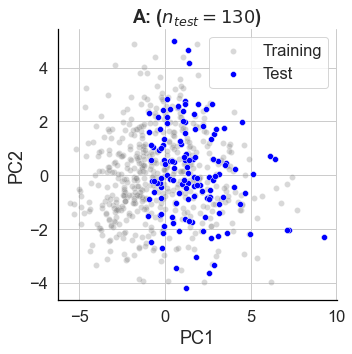

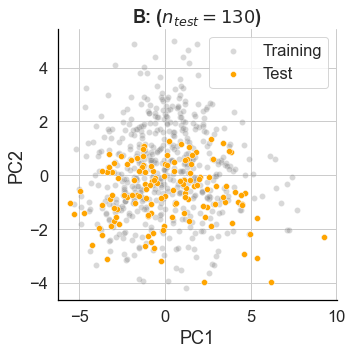

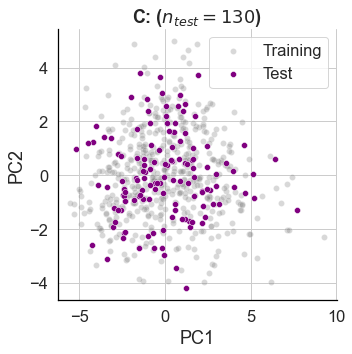

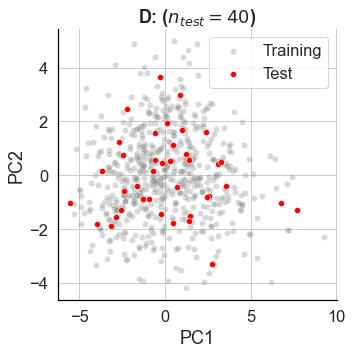

In [5]:

    
def performPCA(X, n_dimensions=2, drop_columns=["Start", "End"]):
    """
    Uses sklearn PCA tool to perform PCA
    input:
    X: Pandas Dataframe or Numpy Array of features
    n_dimensions: Number of PCs to fit
    
    output:
    X_pca: Pandas dataframe with column titles of PC1,...,PCn
    """
    X_data = get_numerical(X)
    if drop_columns: X_data.drop([], axis=1)
    X_standardized = StandardScaler().fit_transform(X_data)
    pca = PCA(n_components=n_dimensions)
    pca.fit(X_standardized)
    X_pca_array = pca.transform(X_standardized)
    column_names = ['PC{}'.format(i+1) for i in range(n_dimensions)] 
    X_pca = pd.DataFrame(X_pca_array, columns=column_names)
    return X_pca

def makeplots(pca_data):
    sns.scatterplot(x="PC1", y="PC2", data=pca_data, color="grey",alpha=.3, label="Training")
    biased_A = pca_data[pca_data["PC1"]>-1]
    sns.scatterplot(x="PC1", y="PC2", data=biased_A.sample(130), color="blue", label="Test")
    plt.title("A: ($n_{test}=130$)", fontweight="bold")
    plt.show()
    sns.scatterplot(x="PC1", y="PC2", data=pca_data, color="grey",alpha=.3, label="Training")
    biased_B = pca_data[pca_data["PC2"]<1.5]
    sns.scatterplot(x="PC1", y="PC2", data=biased_B.sample(130), color="orange", label="Test")
    plt.title("B: ($n_{test}=130$)", fontweight="bold")
    plt.show()
    sns.scatterplot(x="PC1", y="PC2", data=pca_data, color="grey",alpha=.3, label="Training")
    sns.scatterplot(x="PC1", y="PC2", data=pca_data.sample(130), color="purple", label="Test")
    plt.title("C: ($n_{test}=130$)", fontweight="bold")
    plt.show()
    sns.scatterplot(x="PC1", y="PC2", data=pca_data, color="grey",alpha=.3, label="Training")
    sns.scatterplot(x="PC1", y="PC2", data=pca_data.sample(40), color="red", label="Test")
    plt.title(r"D: ($n_{test}=40$)", fontweight="bold")
    plt.show()

pca = performPCA(dataset)
makeplots(pca)


# Question 10: MLR review

We will perform an MLR on __all__ of the quantitative variables in the dataset. _Try to interpret the variables. Does anything seem odd? Compare the coefficients to the original ranges and typical values of the features they are associated with. What features would you take out?

Intercept of MLR model is -18085902845887.27
Regression Coefficients: 
Start ~ -1004772380329.30
End ~ 1004772380329.31
G ~ -0.45
U ~ 1.54
bi ~ 0.07
uni ~ -1.92
duplex ~ 0.62
Pos1 ~ 475972424.00
Pos2 ~ -1.99
Pos6 ~ -1.54
Pos13 ~ -0.76
Pos14 ~ 0.12
Pos18 ~ -475972424.35
Dif_5-3 ~ 475972429.56
Content+ ~ 1.96
Content- ~ -0.79
Cons+ ~ -206686539.11
Cons- ~ 206686538.59
Cons_Sum ~ -206686543.25
Hyb19 ~ -9476.96
target ~ -0.43


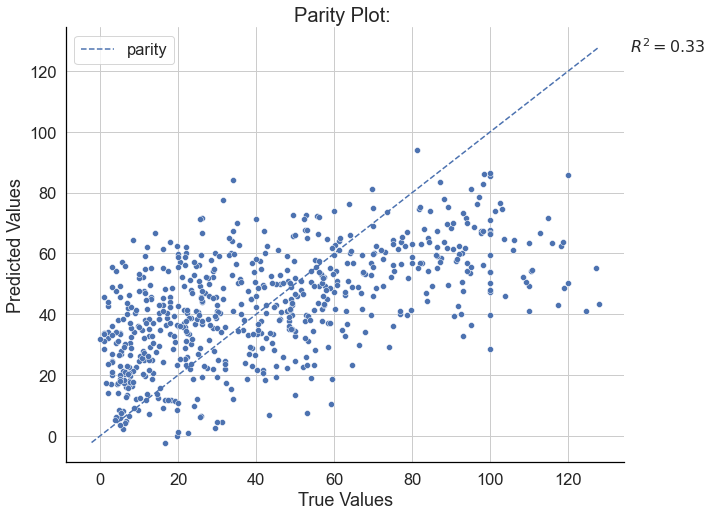

In [6]:
def linear_regression(df, feature_cols, response_col, standardized = False, print_coef=True):
    """
    Use linear_model to run a linear regression using sklearn
    
    """
    X = df[feature_cols]
    y = df[response_col]
    if standardized:
        X = StandardScaler().fit_transform(X)
        y = StandardScaler().fit_transform(y.values.reshape(-1, 1))
    regression = linear_model.LinearRegression() 
    regression.fit(X,y)
    if print_coef:
        try:
            print('Intercept of MLR model is {0:0.2f}'.format(regression.intercept_))
        except TypeError:
            print('Intercept of MLR model is {0:0.2f}'.format(regression.intercept_[0]))
        print('Regression Coefficients: ')
        for feature, coef in zip(feature_cols, regression.coef_.flatten()):
            print(f'{feature} ~ {coef:.2f}')
    return regression.predict(X), regression.score(X,y)

def parity_plot(true, pred, r_squared=None, title='', alpha=None, color=None, hue=None):
    """
    plot true vs the predicted data
    inputs: 2 list-like (arrays) data structures
    """
    fig, ax = plt.subplots(1,1,figsize=(10, 8))
    if hue is not None:
        sns.scatterplot(x=true, y=pred, hue=hue)
    else: 
        if color is None: sns.scatterplot(x=true, y=pred)
        else: sns.scatterplot(x=true, y=pred, alpha=alpha, color=color)
    min_value = min(min(true), min(pred))
    max_value = max(max(true), max(pred))
    plt.plot([min_value, max_value],[min_value, max_value], '--', label="parity")
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    sns.despine()
    plt.text(1.01, 0.98, r"$R^2 = {0:.2f}$".format(r_squared),
         ha='left', va='top', size =LABEL_FONT,
         transform=ax.transAxes)
    plt.title('Parity Plot: {}'.format(title), size=TITLE_FONT)
    plt.legend(loc='best')
    plt.show()    
    
def run_regression(data, 
                   feature_cols = ['Start', 
                                   'End', 
                                   'G', 
                                   'U', 
                                   'bi', 
                                   'uni', 
                                   'duplex', 
                                   'Pos1', 
                                   'Pos2', 
                                   'Pos6', 
                                   'Pos13', 
                                   'Pos14', 
                                   'Pos18', 
                                   'Dif_5-3', 
                                   'Content+', 
                                   'Content-', 
                                   'Cons+', 
                                   'Cons-', 
                                   'Cons_Sum', 
                                   'Hyb19', 
                                   'target'
                                  ], 
                     response_col='Activity',
                     standardized=False,
                     parity=True,
                     ):
    y_pred, r_squared = linear_regression(data, feature_cols, response_col, standardized = standardized)
    if parity: parity_plot(data[response_col], y_pred.flatten(), r_squared)

run_regression(data=num_dataset)



# Question 11: Build your own MLR model

Let's remove some of the problematic features from the previous model. Notice how the coefficient of determination changes as you remove features. 

In [7]:
@widgets.interact()   
def regression_wrapper(Start = True,
                       End = True,
                       G = True,
                       U = True,
                       bi = True,
                       uni = True,
                       duplex = True,
                       Pos1 = True,
                       Pos2 = True,
                       Pos6 = True,
                       Pos13 = True,
                       Pos14 = True,
                       Pos18 = True,
                       Dif_5_3 = True,
                       Content_plus = True,
                       Content_minus = True,
                       Cons_plus = True,
                       Cons_minus = True,
                       Cons_Sum = True,
                       Hyb19 = True,
                       target = True):
    response="Activity"
    features = []
    if Start: features.append('Start')
    if End: features.append('End')
    if G: features.append('G')
    if U: features.append('U')
    if bi: features.append('bi')
    if uni: features.append('uni')
    if duplex: features.append('duplex')
    if Pos1: features.append('Pos1')
    if Pos2: features.append('Pos2')
    if Pos6: features.append('Pos6')
    if Pos13: features.append('Pos13')
    if Pos14: features.append('Pos14')
    if Pos18: features.append('Pos18')
    if Dif_5_3: features.append('Dif_5-3')
    if Content_plus: features.append('Content+')
    if Content_minus: features.append('Content-')
    if Cons_plus: features.append('Cons+')
    if Cons_minus: features.append('Cons-')
    if Cons_Sum: features.append('Cons_Sum')
    if Hyb19: features.append('Hyb19')
    if target: features.append('target')        

    run_regression(data=num_dataset, feature_cols=features, response_col = response)


interactive(children=(Checkbox(value=True, description='Start'), Checkbox(value=True, description='End'), Chec…

# Question 12-13: You are the quantitative biologist now

Go through the process of building the model. You can increase the degrees of your polynomial features, and include interaction terms (covariance) in order to build the model. Notice how the fit of the model changes if you include or don't include a particular value. 

Try to do this without selecting `test`. Use `test` once you're comfortable with the model performance on validation data. 

In [15]:
def cross_validation(model, X, y, k=10):
    scores = cross_validate(model, X, y, cv=k,
                            scoring=('r2', 'neg_root_mean_squared_error'),
                            return_train_score=True)
    
    print(f"Training RMSE: {np.mean(-1*scores['train_neg_root_mean_squared_error']):.2f}")
    print(f"Validation RMSE: {np.mean(-1*scores['test_neg_root_mean_squared_error']):.2f}")
    
    print(f"Training R2: {np.mean(scores['train_r2']):.3f}")
    print(f"Validation R2: {np.mean(scores['test_r2']):.3f}")
    
    return model.fit(X,y)
    
def do_the_thing(X,y , degrees, interactions, test):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    poly = PolynomialFeatures(degrees, include_bias=True)
    # print(poly.get_feature_names_out(input_features=X_train.columns))
    X_train = poly.fit_transform(X_train)
    poly_features = poly.get_feature_names_out()
    X_test = poly.fit_transform(X_test, poly_features)
    X_train_df = pd.DataFrame(X_train, columns=poly_features)
    X_test_df = pd.DataFrame(X_train, columns=poly_features)
    interaction_list = [feat for feat in poly_features if len(feat.split())!=1]
    if not interactions:
        X_train_df = X_train_df.drop(interaction_list, axis=1)
        X_test_df = X_test_df.drop(interaction_list, axis=1)
    print(f"Number of Parameters: {len(X_train_df.columns)}")
    
    model = linear_model.LinearRegression(fit_intercept=False) 
    cross_validation(model, X_train_df, y_train)
    if test:
        model.fit(X_train_df, y_train)
        y_train_pred = model.predict(X_train_df)
        print(X_test_df.shape)
        y_test_pred = model.predict(X_test_df)
        parity_plot(y_train, y_train_pred.flatten(), r_squared =model.score(X_train_df, y_train), title="Training Data", color="grey", alpha=0.5)
        parity_plot(y_test, y_test_pred.flatten(), r_squared =model.score(X_test_df, y_test), title="Test Data", color="blue", alpha=1)
        
    return X_train, X_test, y_train, y_test
    
    
    
    
@widgets.interact(degrees=(1,4))
def run(degrees=1, 
        interactions=False,
        Start = True,
        End = True,
        G = True,
        U = True,
        bi = True,
        uni = True,
        duplex = True,
        Pos1 = True,
        Pos2 = True,
        Pos6 = True,
        Pos13 = True,
        Pos14 = True,
        Pos18 = True,
        Dif_5_3 = True,
        Content_plus = True,
        Content_minus = True,
        Cons_plus = True,
        Cons_minus = True,
        Cons_Sum = True,
        Hyb19 = True,
        target = True,
        test=False):
    
    response="Activity"
    features = []
    if Start: features.append('Start')
    if End: features.append('End')
    if G: features.append('G')
    if U: features.append('U')
    if bi: features.append('bi')
    if uni: features.append('uni')
    if duplex: features.append('duplex')
    if Pos1: features.append('Pos1')
    if Pos2: features.append('Pos2')
    if Pos6: features.append('Pos6')
    if Pos13: features.append('Pos13')
    if Pos14: features.append('Pos14')
    if Pos18: features.append('Pos18')
    if Dif_5_3: features.append('Dif_5-3')
    if Content_plus: features.append('Content+')
    if Content_minus: features.append('Content-')
    if Cons_plus: features.append('Cons+')
    if Cons_minus: features.append('Cons-')
    if Cons_Sum: features.append('Cons_Sum')
    if Hyb19: features.append('Hyb19')
    if target: features.append('target')  
    X=num_dataset[features]
    y=num_dataset[response]
    

    do_the_thing(X,y,degrees,interactions, test)


interactive(children=(IntSlider(value=1, description='degrees', max=4, min=1), Checkbox(value=False, descripti…

# Question 14: Other supervised approaches

Congratulations, you are now equipped with enough knowledge to evaluate other types of models rather than solely linear regression (Be careful though, the assumptions and hyperparameters from these other models are __much__ more complicated than MLR, but understanding MLR does equip you to understand these other models). I have proposed three different models, with some minor optimization. (You don't need to know the details, but I am happy to explain if you want to know more)
- Random Forest: an ensemble of 100 boosted decision trees, averaged to get a final result.
- Support Vector Machines: Similarly to polynomial features, we put the features into a different parameter space, and then perform a regression on those new features. In this case we are using a Radial Basis Function. 
- Neural Network: Using a bunch of manipulations, neural networks learn features from the original features, and fit a new model. It is based on using Rectified Linear Units.

It's okay if that sounds intimidating. Anytime I learn a new ML algorithm it is still intimidating. That being said, we can still use these models and evaluate their performance in the same way as we've been doing. 
__Note: Even if we can evaluate these models, without understanding the underlying math we cannot understand the ramification of these assumptions on interpreting parameters__. 


In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from sklearn import ensemble, neural_network, svm

def rf(X,y):
    print('-'*30)
    print("Random Forest (boosted trees)")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = ensemble.GradientBoostingRegressor(loss='absolute_error', learning_rate=.05, alpha=0.2)
    cross_validation(model, X_train, y_train)
    model.fit(X_train,y_train)
    r2_test = model.score(X_test,y_test)
    print(f"\nTest R2: {r2_test:.2f}")
    model.fit(X,y)
    r2 = model.score(X,y)
    y_pred = model.predict(X )
    parity_plot(y, y_pred, r_squared=r2,   title="RF, all data")
    
def svr(X,y):
    print('-'*30)
    print("Support Vector Regression")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = svm.SVR(kernel="rbf",gamma="scale", C=1000)
    cross_validation(model, X_train, y_train)
    model.fit(X_train,y_train)
    r2_test = model.score(X_test,y_test)
    print(f"\nTest R2: {r2_test:.2f}")
    model.fit(X,y)
    r2 = model.score(X,y)
    y_pred = model.predict(X )
    parity_plot(y, y_pred, r_squared=r2,  title="SVR, all data")
    
def nn(X,y):
    print('-'*30)
    print("Neural Network Regression (Multi-layer perceptron)")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = neural_network.MLPRegressor(hidden_layer_sizes=(30,30),
                                        learning_rate='invscaling',
                                        activation="relu", 
                                        max_iter=1000)
    cross_validation(model, X_train, y_train)
    model.fit(X_train,y_train)
    r2_test = model.score(X_test,y_test)
    print(f"\nTest R2: {r2_test:.2f}")
    model.fit(X,y)
    r2 = model.score(X,y)
    y_pred = model.predict(X )
    parity_plot(y, y_pred, r_squared=r2, title="NN, all data")
    
features = ['bi', 'uni', 'duplex', 
            'Pos1', 'Pos2', 'Pos6', 'Pos13', 'Pos14', 'Pos18', 
            'Dif_5-3', 'Content+', 
            'Cons+', 'Cons-', 'Cons_Sum', 'Hyb19', 'target']

X= num_dataset[features]
y= num_dataset["Activity"]

rf(X,y)
svr(X,y)
nn(X,y)